In [74]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
!pip install dmba
from dmba import classificationSummary

In [2]:
ebay = pd.read_excel("ebayAuctions.xlsx", sheet_name=1)

### 1. Converting the Currency Units Based on Exchange Rates

In [3]:
rates = {"US": 1.00, "EUR": 1.17, "GBP": 1.34}
ebay["OpenPriceUSD"] = ebay.apply(lambda row: row["OpenPrice"] * rates[row["Currency"]], axis=1)
ebay["ClosePriceUSD"]  = ebay.apply(lambda row: row["ClosePrice"]  * rates[row["Currency"]], axis=1)

### 2. Applying Log Transformation on Numeric Variables with Outliers

In [4]:
ebay["logOpenPriceUSD"] = np.log(ebay["OpenPriceUSD"])
ebay["logClosePriceUSD"] = np.log(ebay["ClosePriceUSD"])
ebay.drop(columns=['Currency', 'ClosePrice', 'OpenPrice', 'OpenPriceUSD', 'ClosePriceUSD'], inplace=True)

In [5]:
ebay.describe()

,sellerRating,Duration,Competitive?,logOpenPriceUSD,logClosePriceUSD
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,0.540568,1.251404,2.490251
std,5973.011033,2.052906,0.498478,2.081962,1.571387
min,0.000000,1.000000,0.000000,-4.605170,-4.605170
25%,595.000000,5.000000,0.000000,0.364018,1.607436
50%,1853.000000,7.000000,1.000000,1.599388,2.378379
75%,3380.000000,7.000000,1.000000,2.396986,3.399529
max,37727.000000,10.000000,1.000000,6.906755,6.917743


### 3. Create Dummy Variables for Categorical Predictors

In [6]:
categorical_predictors = ['Category', 'Duration', 'endDay']
numeric_predictors = ['sellerRating', 'logOpenPriceUSD', 'logClosePriceUSD']

In [7]:
preprocessor = ColumnTransformer([
    ("numeric", "passthrough", numeric_predictors),
    ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_predictors)
])

### 4. Full Decision Tree with Minimum 50 Records per Terminal Node

In [8]:
ebayX = ebay[['Category', 'sellerRating', 'Duration', 'endDay', 'logOpenPriceUSD', 'logClosePriceUSD']]
ebayY = ebay['Competitive?']
X_train, X_test, y_train, y_test = train_test_split(ebayX, ebayY, test_size = 0.4, random_state = 123)

In [9]:
tree_full = DecisionTreeClassifier(min_samples_leaf = 50, random_state = 123)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("tree", tree_full)
])

In [10]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('tree', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
print("Train accuracy:", pipe.score(X_train, y_train))
print("Test accuracy :", pipe.score(X_test, y_test))

Train accuracy: 0.8233305156382079
Test accuracy : 0.7921419518377694


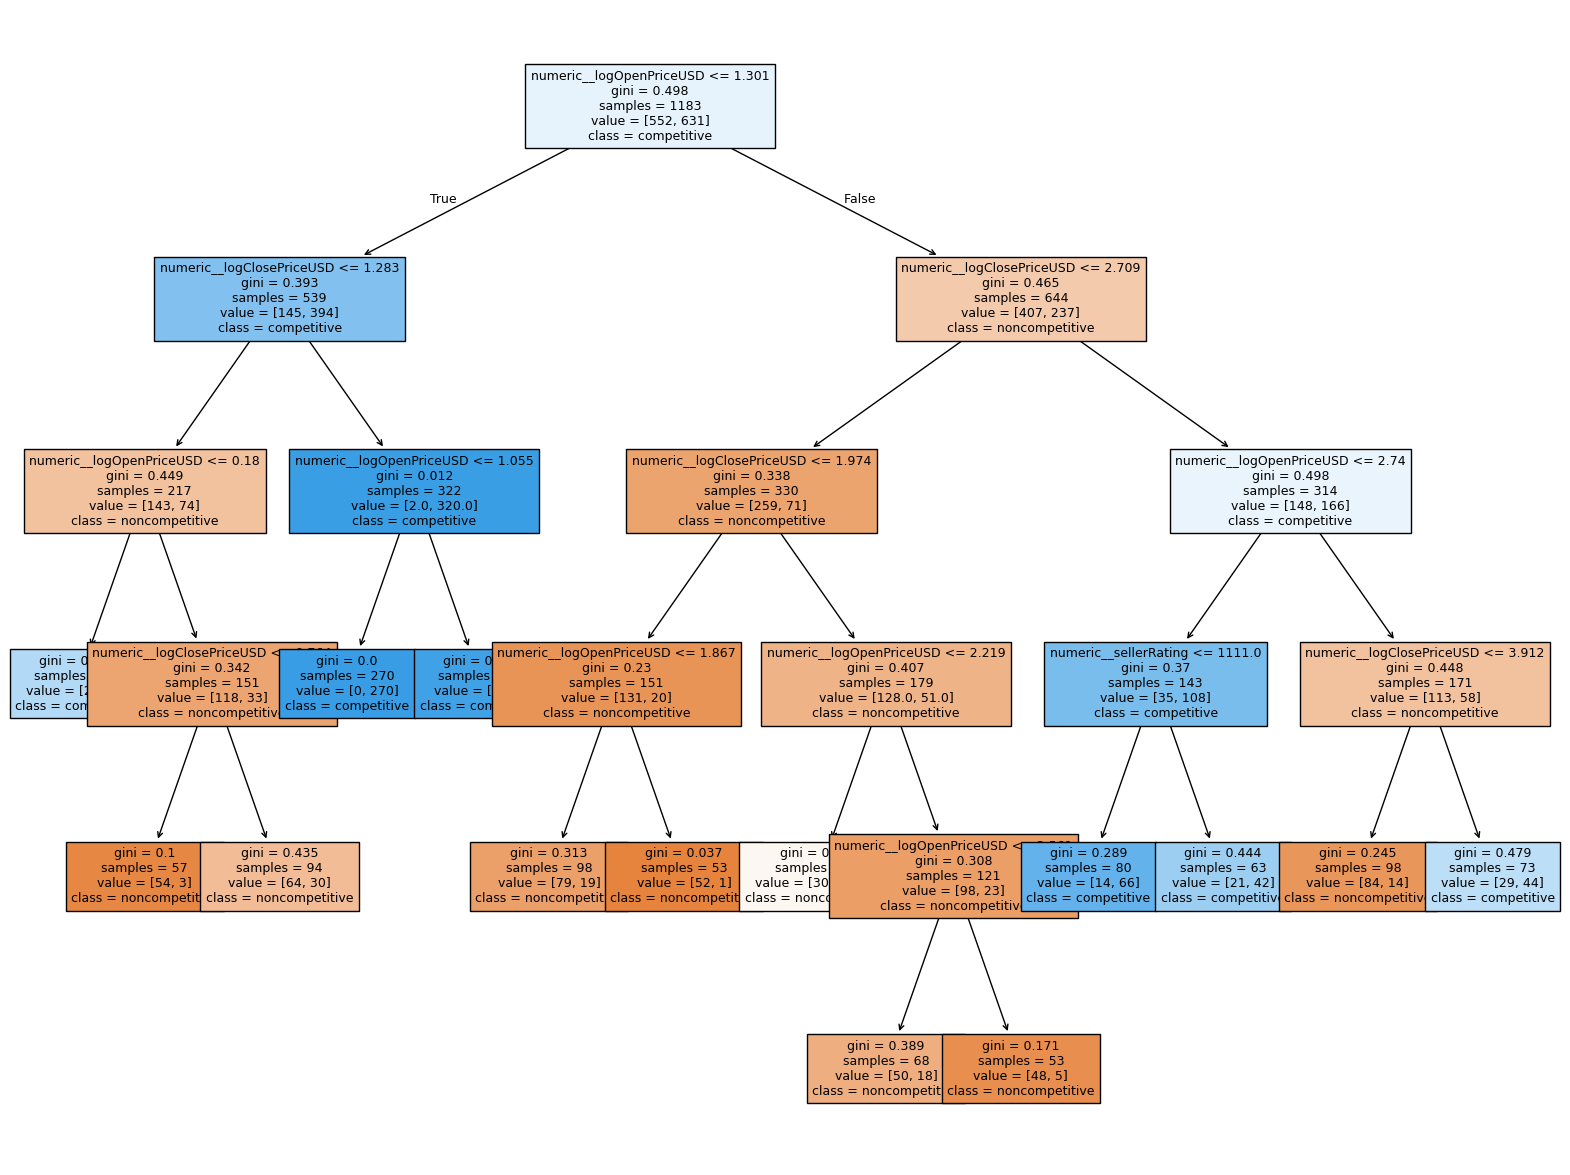

In [12]:
plt.figure(figsize = (20,15))
plot_tree(pipe.named_steps["tree"],
          feature_names = pipe.named_steps["preprocessor"].get_feature_names_out(),
          class_names = ["noncompetitive", "competitive"],
          filled = True,
          fontsize = 9)
plt.show()

## Full Decision Tree Interpretation

### 1. Root Split: Opening Price (Most Important Factor)
- **Split:** `logOpenPriceUSD <= 1.301`  
- **Interpretation:**  
  - Low opening prices (≤ 1.30) → tend toward **competitive** auctions  
  - High opening prices (> 1.30) → tend toward **non-competitive** auctions  

---

### 2. Left Subtree (Low Opening Price)
- **If** `logClosePriceUSD <= 1.283`:
  - **Check** `logOpenPriceUSD <= 1.055`:
    - `≤ 1.055` → **very competitive** (270 competitive vs 0 non-competitive)  
    - `> 1.055` → mostly non-competitive (131 non-competitive vs 201 competitive → ~39% competitive)  
  - **Intuition:** Auctions starting very low (below ~1.05 log units) almost always get multiple bidders  

- **If** `logClosePriceUSD > 1.283`:
  - Mixture, but many branches remain **competitive**  
  - Some leaves (e.g., `logOpenPriceUSD <= 0.18`) are **non-competitive** — ultra-low opening prices but very low closing prices may indicate poor items or low demand  

---

### 3. Right Subtree (High Opening Price)
- **If** `logClosePriceUSD <= 2.709`:
  - Strongly **non-competitive** (407 non-competitive vs 237 competitive → ~63% non-competitive)  
  - High starting price + low ending price usually means only one bidder was willing to meet the reserve  

- **If** `logClosePriceUSD > 2.709`:
  - Further split:  
    - `logOpenPriceUSD <= 2.74` **and** `sellerRating <= 1111` → **competitive** (108 competitive vs 35 non-competitive → ~75% competitive)  
    - Otherwise → mixed, but several branches remain mostly **non-competitive**  
  - **Insight:** High opening prices generally discourage bidding. However, if the auction closes high and the seller has a decent reputation, multiple bidders may still compete → some high-price auctions can be competitive

### Obvious Findings
1. Low opening price drives competitiveness. Auctions that start cheap attract more bidders.

2. High opening price discourages competition. Most high-start auctions end up noncompetitive.

### Unexpected Findings
1. Seller reputation matters only in special cases. Among auctions with both high opening and closing prices, lower seller ratings (≤ 1111) were actually more likely to be competitive.
2. Duration and category barely show up in the splits.
3. Not all low-start auctions are competitive. Some very low open/close auctions still ended noncompetitive — possibly for undesirable items/categories.
4. High close price isn’t always competitive. At high opening prices, many auctions remain noncompetitive even if the final price is high — suggesting one serious buyer rather than multiple bidders.

### 5. Reduce the Number of Predictors 

In [57]:
X_simple_train = X_train[['logOpenPriceUSD','logClosePriceUSD']]
X_simple_test = X_test[['logOpenPriceUSD','logClosePriceUSD']]

In [58]:
tree_simple = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)
tree_simple.fit(X_simple_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### 5.1 Resulting Tree Simple

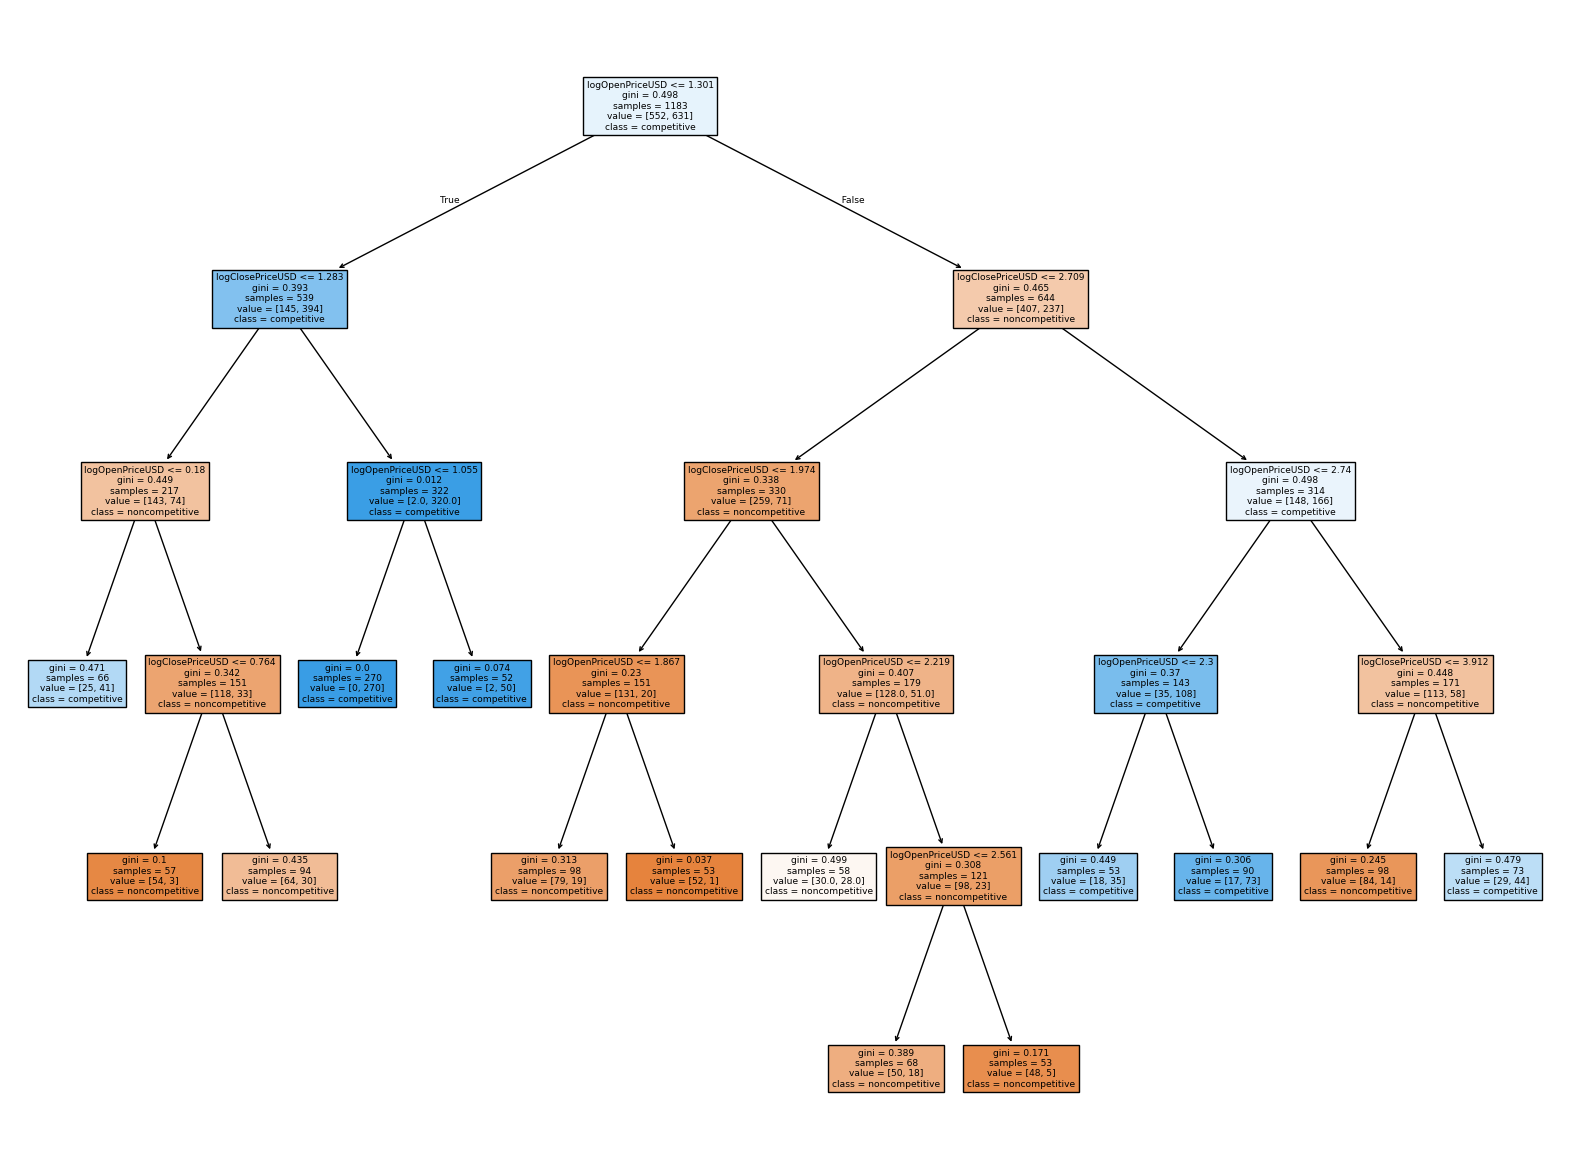

In [59]:
plt.figure(figsize=(20,15))
plot_tree(tree_simple, feature_names=X_simple_train.columns, class_names=["noncompetitive", "competitive"], filled=True)
plt.show()

In [90]:
from sklearn.tree import export_text

# Suppose your tree is tree_simple and predictors are X_simple.columns
tree_text = export_text(tree_simple, feature_names=list(X_simple_train.columns))
print(tree_text)

|--- logOpenPriceUSD <= 1.30
|   |--- logClosePriceUSD <= 1.28
|   |   |--- logOpenPriceUSD <= 0.18
|   |   |   |--- class: 1
|   |   |--- logOpenPriceUSD >  0.18
|   |   |   |--- logClosePriceUSD <= 0.76
|   |   |   |   |--- class: 0
|   |   |   |--- logClosePriceUSD >  0.76
|   |   |   |   |--- class: 0
|   |--- logClosePriceUSD >  1.28
|   |   |--- logOpenPriceUSD <= 1.06
|   |   |   |--- class: 1
|   |   |--- logOpenPriceUSD >  1.06
|   |   |   |--- class: 1
|--- logOpenPriceUSD >  1.30
|   |--- logClosePriceUSD <= 2.71
|   |   |--- logClosePriceUSD <= 1.97
|   |   |   |--- logOpenPriceUSD <= 1.87
|   |   |   |   |--- class: 0
|   |   |   |--- logOpenPriceUSD >  1.87
|   |   |   |   |--- class: 0
|   |   |--- logClosePriceUSD >  1.97
|   |   |   |--- logOpenPriceUSD <= 2.22
|   |   |   |   |--- class: 0
|   |   |   |--- logOpenPriceUSD >  2.22
|   |   |   |   |--- logOpenPriceUSD <= 2.56
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- logOpenPriceUSD >  2.56
|   |   |   |   

#### 5.2 Resulting Tree Simple on a Scatter Plot

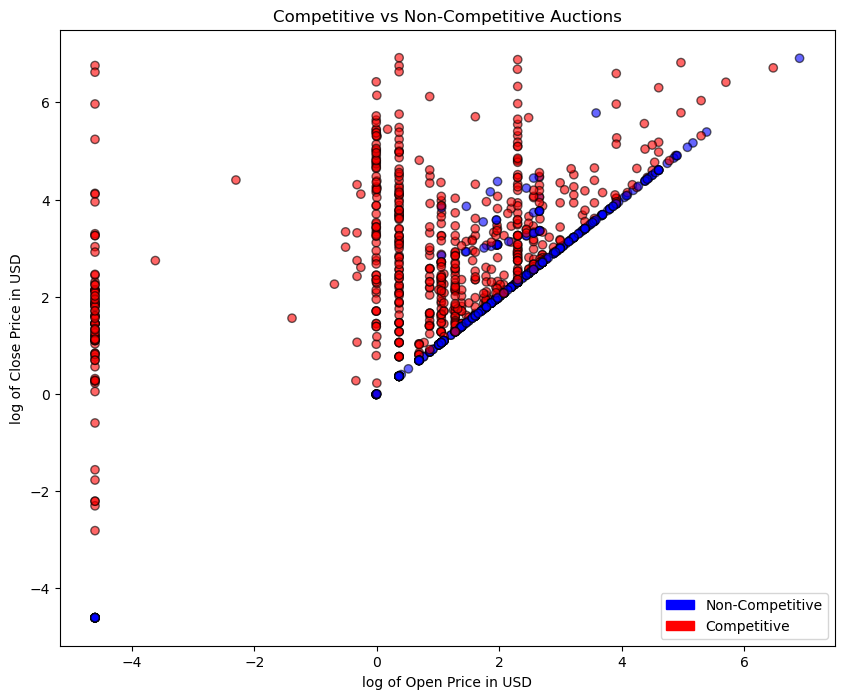

In [60]:
plt.figure(figsize = (10,8))
plt.scatter(
    X_simple_train['logOpenPriceUSD'], 
    X_simple_train['logClosePriceUSD'], 
    c = y_train,         
    cmap = 'bwr',             
    alpha = 0.6,
    edgecolor = 'k'
)
blue = mpatches.Patch(color = 'blue', label = 'Non-Competitive')
red = mpatches.Patch(color = 'red', label = 'Competitive')
plt.legend(handles = [blue, red])

plt.xlabel('log of Open Price in USD')
plt.ylabel('log of Close Price in USD')
plt.title('Competitive vs Non-Competitive Auctions')

plt.show()

#### 5.3 Confusion Matrix of Tree Simple

In [82]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index=['Actual Non-competitive', 'Actual Competitive'],
                     columns=['Pred Non-competitive', 'Pred Competitive'])
print(cm_df)

                        Pred Non-competitive  Pred Competitive
Actual Non-competitive                   291                63
Actual Competitive                       101               334


- Hit Rate (Accuracy): 79.2%

- Precision (Competitive auctions): 84.1%

- Recall (Competitive auctions): 76.8%

- Specificity (Non-Competitive auctions): 82.2%

#### Summary
- The model performs reasonably well overall  
- It is slightly better at predicting non-competitive auctions (specificity 82.2%) than competitive ones (recall 76.8%).  
- Precision is high (84.1%), meaning predictions of competitiveness are reliable.  
- Overall, the hit rate of 79.2% indicates the model captures most of the auctions correctly.

In [89]:
ebay["Competitive?"].value_counts()

Competitive?
1    1066
0     906
Name: count, dtype: int64

#### 5.4 Chances of an Auction to Be Competitive and Its Relationship to the Auction Settings Set by the Seller

Out of 1972 auctions: 1066 were competitive → 54% chance overall.
Because Duration, Ending day, and Currency do not appear in any splits of the decision tree, they are not effective in distinguishing competitive from non-competitive auctions, at least relative to the much stronger predictors log of open price in USD and log of close price in USD.

#### 5.5 Recommendation for a Seller as the Strategy That Will Most Likely Lead to a Competitive Auction

Based on the decision tree analysis, the opening price is the dominant factor influencing whether an auction will be competitive. Very low or moderately priced openings tend to attract more bidders and increase the chance of obtaining at least two bids. Only set high opening price if you believe that the item worths it. Other auction settings, such as duration, ending day, or currency, have little effect. 

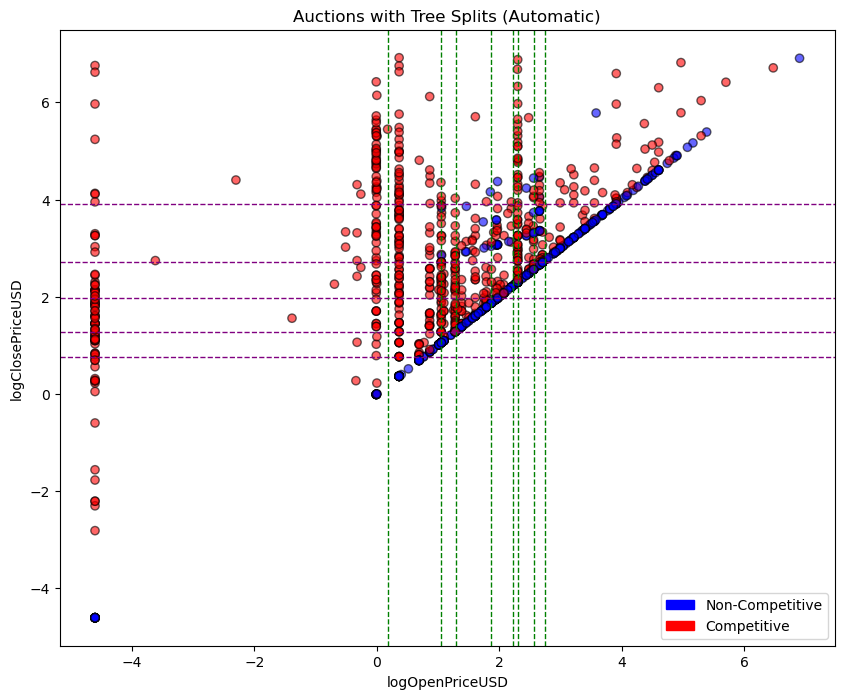

In [55]:
### Not finish
import matplotlib.patches as mpatches

# Assume tree_simple is your fitted pruned tree
features = list(X_simple.columns)
tree = tree_simple.tree_

# Extract all split thresholds
split_logOpen = []
split_logClose = []

for i in range(tree.node_count):
    if tree.children_left[i] != tree.children_right[i]:  # non-leaf node
        feature = features[tree.feature[i]]
        threshold = tree.threshold[i]
        if feature == 'logOpenPriceUSD':
            split_logOpen.append(threshold)
        elif feature == 'logClosePriceUSD':
            split_logClose.append(threshold)

# Scatter plot
plt.figure(figsize=(10,8))
plt.scatter(X_simple['logOpenPriceUSD'], X_simple['logClosePriceUSD'],
            c=y_train, cmap='bwr', alpha=0.6, edgecolor='k')

# Draw split lines automatically
for s in split_logOpen:
    plt.axvline(x=s, color='green', linestyle='--', linewidth=1)

for s in split_logClose:
    plt.axhline(y=s, color='purple', linestyle='--', linewidth=1)

# Add legend for classes
blue_patch = mpatches.Patch(color='blue', label='Non-Competitive')
red_patch = mpatches.Patch(color='red', label='Competitive')
plt.legend(handles=[blue_patch, red_patch])

plt.xlabel('logOpenPriceUSD')
plt.ylabel('logClosePriceUSD')
plt.title('Auctions with Tree Splits (Automatic)')
plt.show()